In [1]:
# Standard libraries
import sys
import time

# Third party libraries
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import scipy.ndimage
from scipy.ndimage import median_filter
from sklearn.neighbors import KernelDensity

# Our libraries
sys.path.append('../../')
from gui.gui_shared import auto_contrast

## Functions

In [2]:
def readTifWrapper(i, file_name):
    """
    i - index for parallel processing
    file_name - file name to open
    """
    image = readTifSection(str(file_name))
    return [i, image]


def readTifSection(file_path):
    """
    Read tif section image using SITK
    """
    image = sitk.ReadImage(str(file_path))
    image = sitk.GetArrayFromImage(image)
    image[image < 0] = 0
    image = image.T
    image = np.flip(image, axis=0)
    image = np.flip(image, axis=1)
    image  = np.squeeze(image)
    return image


def n4_bias_correction(img, alpha=1, shrink_factor=25, show=False):
    """
    N4 bias correction
    """
    # Get contrast image for mask
    contrast_img = auto_contrast(img, alpha=alpha)
    
    # Create the brain tissue mask
    mask_img = sitk.GetImageFromArray(contrast_img)
    mask_img = sitk.RescaleIntensity(mask_img, 0, 255)
    mask_img = sitk.LiThreshold(mask_img, 0, 1)

    # Use the raw image and convert it to float32
    raw_img = sitk.GetImageFromArray(img.copy())
    raw_img = sitk.Cast(raw_img, sitk.sitkFloat32)

    # Downsample it for bias correction
    inputImage = raw_img
    if shrink_factor > 1:
        inputImage = sitk.Shrink( raw_img, [ shrink_factor ] * raw_img.GetDimension() ) #2
        maskImage = sitk.Shrink( mask_img, [ shrink_factor ] * inputImage.GetDimension() ) #3

    # Run bias correction
    start_time = time.time()
    bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected = bias_corrector.Execute(inputImage, maskImage)
    
    # Apply bias correction to full resolution image
    log_bias_field = bias_corrector.GetLogBiasFieldAsImage(raw_img)
    corrected_image_full_resolution = raw_img / sitk.Exp(log_bias_field)
    end_time = time.time()
    corrected_image_full_resolution = sitk.GetArrayFromImage(corrected_image_full_resolution)
    
    # Show the process if True
    if show:
        print(f"Time taken for bias correction: {end_time - start_time:.2f} seconds")
        
        # Show the brain tissue mask
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(sitk.GetArrayFromImage(mask_img), cmap='gray')
        plt.title(f"Full resolution brain mask")
        plt.subplot(1, 2, 2)
        plt.imshow(sitk.GetArrayFromImage(maskImage), cmap='gray')
        plt.title(f"Downsampled brain mask (shrink factor={shrink_factor})")
        plt.show()
        
        # Show the log bias field
        plt.figure(figsize=(10, 5))
        plt.imshow(sitk.GetArrayFromImage(log_bias_field))
        plt.colorbar()
        plt.title(f"Log bias field")
        plt.show()

        # Show the corrected bias field image
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original raw image")
        plt.subplot(1, 2, 2)
        plt.imshow(corrected_image_full_resolution, cmap='gray')
        plt.title(f"Corrected bias raw image")
        plt.show()

        # Increase the contrast of the corrected image and show side-by-side
        preview_alpha = 0.25
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        contrast_comparison = auto_contrast(img, alpha=preview_alpha)
        plt.imshow(contrast_comparison, cmap='gray')
        plt.title(f"Original contrast image (alpha={preview_alpha})")
        plt.subplot(1, 2, 2)
        corrected_bias_contrast = auto_contrast(corrected_image_full_resolution, alpha=preview_alpha)
        plt.imshow(corrected_bias_contrast, cmap='gray')
        plt.title(f"Corrected bias contrast image (alpha={preview_alpha})")
        plt.show()
        
    return corrected_image_full_resolution


def show_crop(img, points=None, x_crop=[6100, 7600], y_crop=[2450, 3300], 
              title="Image", cmap='gray', colorbar=False):
    """
    Show the crop of the image
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(img, cmap=cmap)
    if points is not None:
        for point in points:
            plt.plot(point[1], point[0], 'ro', markersize=1)
    plt.title(title)
    if x_crop is not None:
        plt.xlim(x_crop)
    if y_crop is not None:
        plt.ylim(y_crop[::-1])
    if colorbar:
        plt.colorbar()
    plt.show()
    
    
def compute_dice_coefficient(binary_image1, binary_image2):
    """
    Compute the Dice coefficient between two binary images.
    
    Parameters:
    - binary_image1: 2D numpy array representing the first binary image.
    - binary_image2: 2D numpy array representing the second binary image.
    
    Returns:
    - dice_coefficient: The Dice coefficient between the two binary images.
    """
    intersection = np.logical_and(binary_image1, binary_image2)
    return 2. * intersection.sum() / (binary_image1.sum() + binary_image2.sum())


def get_stats(img, title="", show=True):
    """
    Print the statistics of the image.
    """
    img_min = np.min(img)
    img_max = np.max(img)
    img_median = np.median(img)
    img_mean = np.mean(img)
    img_std = np.std(img)
    if show:
        if title:
            print(title)
        print("\tShape:", img.shape)
        print("\tMin:", img_min)
        print("\tMax:", img_max)
        print("\tMedian:", img_median)
        print("\tMean:", img_mean)
        print("\tStd:", img_std)
        print()
    return img_min, img_max, img_median, img_mean, img_std
    


def preprocess_image(img, alpha=1, shrink_factor=10, 
                     median_filter_size=5, gaussian_sigma=0.2, 
                     show=False):
    """
    Preprocess the image using N4 bias correction and filtering.
    
    Parameters:
    - img: The input image to preprocess.
    - alpha: The alpha value for contrast adjustment.
    - shrink_factor: The shrink factor for downsampling the image for bias correction.
    - median_filter_size: The size of the median filter to apply.
    - gaussian_sigma: The sigma value for the Gaussian filter to apply.
    - show: Whether to show the intermediate results.
    
    Returns:
    - corrected_img: The preprocessed image.
    """
    corrected_bias_img = n4_bias_correction(img, alpha=alpha, shrink_factor=shrink_factor, show=show)

    # Run median filter
    median_filtered_img = median_filter(corrected_bias_img.copy(), size=median_filter_size)

    # Run gaussian filter
    gaussian_filtered_img = scipy.ndimage.gaussian_filter(median_filtered_img.copy(), sigma=gaussian_sigma)

    if show:
        print("Original image stats:")
        print(np.min(img), np.max(img))
        print(np.median(img))
        print(np.mean(img))

        print("\nN4 bias corrected image stats:")
        print("Min:", np.min(corrected_bias_img), "Max:", np.max(corrected_bias_img))
        print("Median:", np.median(corrected_bias_img))
        print("Mean:", np.mean(corrected_bias_img))

        print("\nMedian filtered image stats:")
        print("Min:", np.min(median_filtered_img), "Max:", np.max(median_filtered_img))
        print("Median:", np.median(median_filtered_img))
        print("Mean:", np.mean(median_filtered_img))
    
        print("\nGaussian filtered image stats:")
        print("Min:", np.min(gaussian_filtered_img), "Max:", np.max(gaussian_filtered_img))
        print("Median:", np.median(gaussian_filtered_img))
        print("Mean:", np.mean(gaussian_filtered_img))
    
    corrected_img = gaussian_filtered_img        
    return corrected_img

### Load in tiff data

Brain shape: (8716, 11236)
Ground truth (section 140) shape: (66, 2)


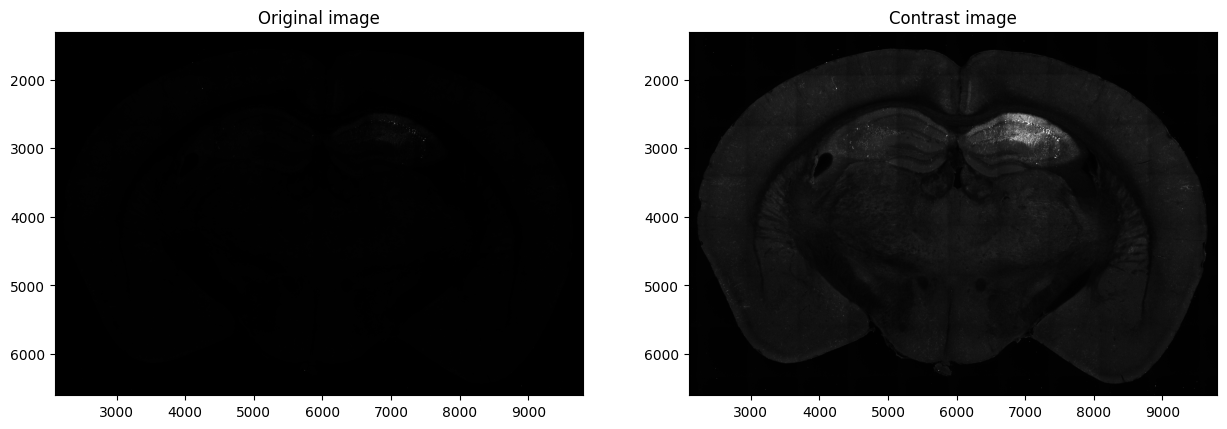

In [3]:
# Parameters for loading in the data
img_path = "/media/data/u01/B0039/stitched_ch0/230628_B0039_PG_U01_280-0140_1_0.tif"
gt140_path = "/media/data/u01/B0039/red_section140_counts_240930_PG/red_section140_counts_240930_PG.txt"

# Load in the images
img = readTifSection(img_path)
print("Brain shape:", img.shape)

gt_points = np.loadtxt(gt140_path, skiprows=2)
gt_points = gt_points[:, 1:]  # Remove section index row
print("Ground truth (section 140) shape:", gt_points.shape)

# Contrast section
contrast_img = auto_contrast(img, alpha=0.1)

# Plot the image and contrast image
x_boundary = (2100, 9800)  # Crop out most of the background
y_boundary = (1300, 6600)
x_dca1_boundary = (6100, 7600)  # Crop the section to the region of interest
y_dca1_boundary = (2450, 3300)
x_roi_boundary = (7100, 7400)  # Crop the section to the region of interest
y_roi_boundary = (2600, 2900)

plt.figure(figsize=(15, 5))  # 20, 10
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(f"Original image")
plt.xlim(x_boundary)
plt.ylim(y_boundary[::-1])
plt.subplot(1, 2, 2)

plt.imshow(contrast_img, cmap='gray')
plt.title(f"Contrast image")
plt.xlim(x_boundary)
plt.ylim(y_boundary[::-1])
plt.show()

Perform N4 bias correction

https://medium.com/@alexandro.ramr777/how-to-do-bias-field-correction-with-python-156b9d51dd79

Original image stats:
0 31877
17.0
66.66915517812917
N4 bias corrected image stats:
0.0 30047.967716928382
18.40305573876823
65.20032037938365


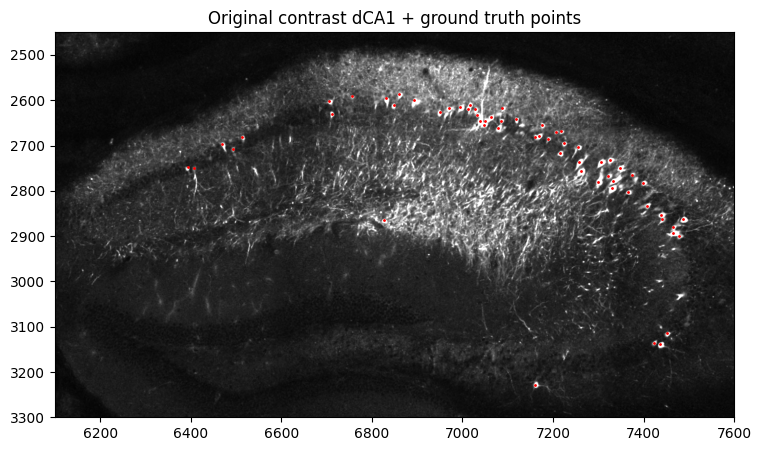

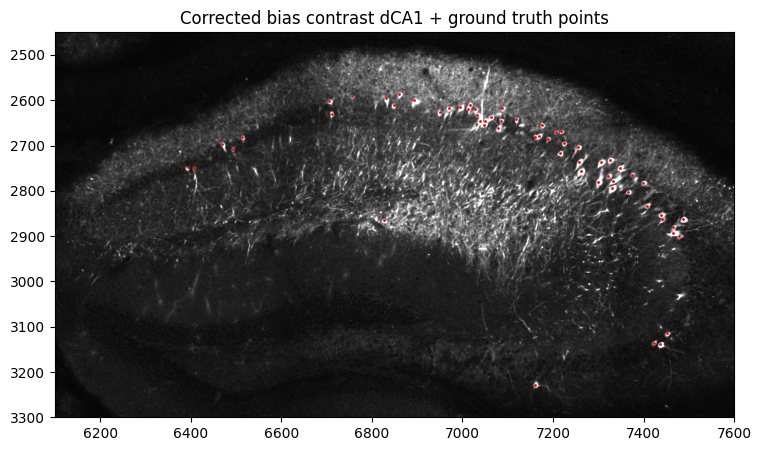

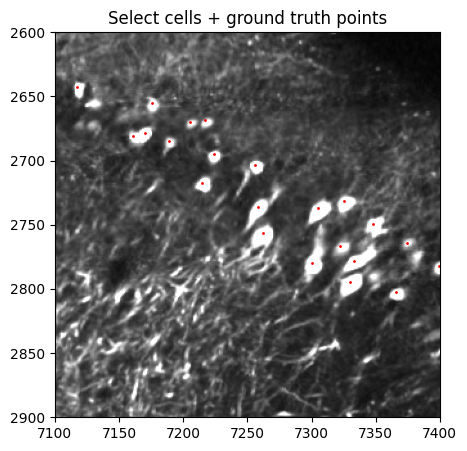

In [4]:
corrected_bias_img = n4_bias_correction(img, alpha=1, shrink_factor=10, show=False)

print("Original image stats:")
print(np.min(img), np.max(img))
print(np.median(img))
print(np.mean(img))

print("N4 bias corrected image stats:")
print(np.min(corrected_bias_img), np.max(corrected_bias_img))
print(np.median(corrected_bias_img))
print(np.mean(corrected_bias_img))

contrast_corrected_bias_img = auto_contrast(corrected_bias_img, alpha=0.1)
show_crop(contrast_img, points=gt_points, title="Original contrast dCA1 + ground truth points")
show_crop(contrast_corrected_bias_img, points=gt_points, title="Corrected bias contrast dCA1 + ground truth points")
show_crop(contrast_corrected_bias_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title="Select cells + ground truth points")

### Median filter

N4 bias corrected image stats:
Min: 0.0 Max: 30047.967716928382
Median: 18.40305573876823
Mean: 65.20032037938365

Median filtered image stats:
Min: 0.0 Max: 25193.603518968393
Median: 17.627450899646366
Mean: 63.983521536105535


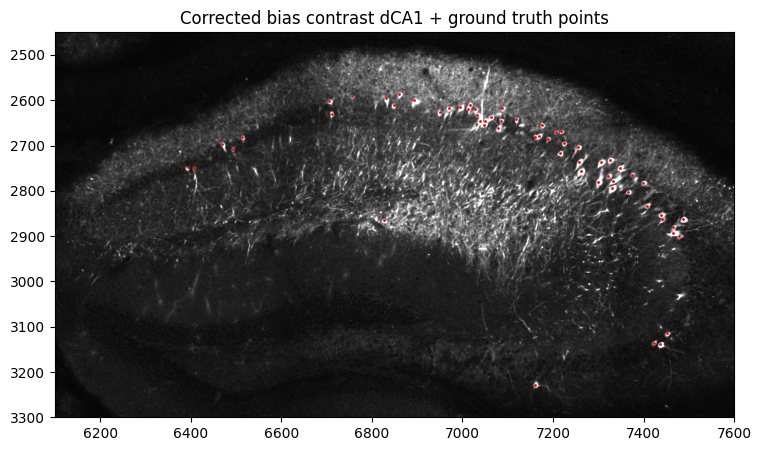

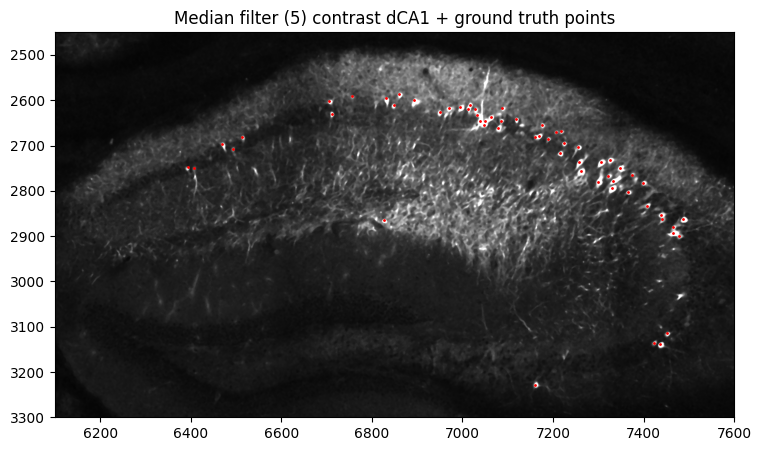

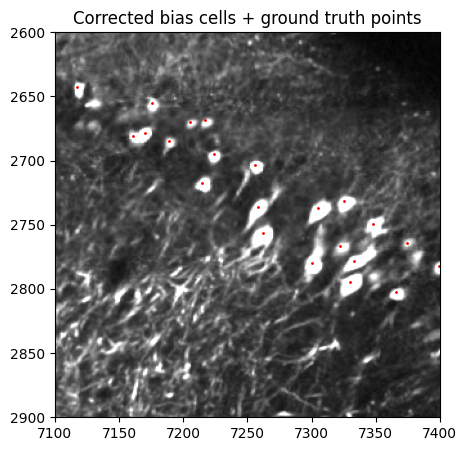

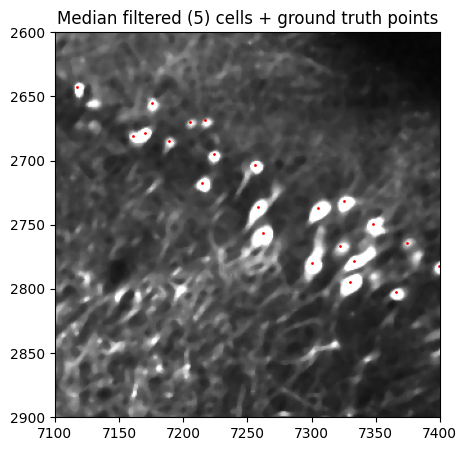

In [5]:
median_filter_size = 5

# Run median filter
median_filtered_img = median_filter(corrected_bias_img.copy(), size=median_filter_size)

print("N4 bias corrected image stats:")
print("Min:", np.min(corrected_bias_img), "Max:", np.max(corrected_bias_img))
print("Median:", np.median(corrected_bias_img))
print("Mean:", np.mean(corrected_bias_img))

print("\nMedian filtered image stats:")
print("Min:", np.min(median_filtered_img), "Max:", np.max(median_filtered_img))
print("Median:", np.median(median_filtered_img))
print("Mean:", np.mean(median_filtered_img))

contrast_median_filtered_img = auto_contrast(median_filtered_img, alpha=0.1)
show_crop(contrast_corrected_bias_img, points=gt_points, title="Corrected bias contrast dCA1 + ground truth points")
show_crop(contrast_median_filtered_img, points=gt_points, title=f"Median filter ({median_filter_size}) contrast dCA1 + ground truth points")
show_crop(contrast_corrected_bias_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title="Corrected bias cells + ground truth points")
show_crop(contrast_median_filtered_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, 
          title=f"Median filtered ({median_filter_size}) cells + ground truth points")

### Gaussian filter

Median filtered image stats:
Min: 0.0 Max: 25193.603518968393
Median: 17.627450899646366
Mean: 63.983521536105535

Gaussian filtered image stats:
Min: 0.0 Max: 25193.601048856446
Median: 17.627451017744843
Mean: 63.983521536105954


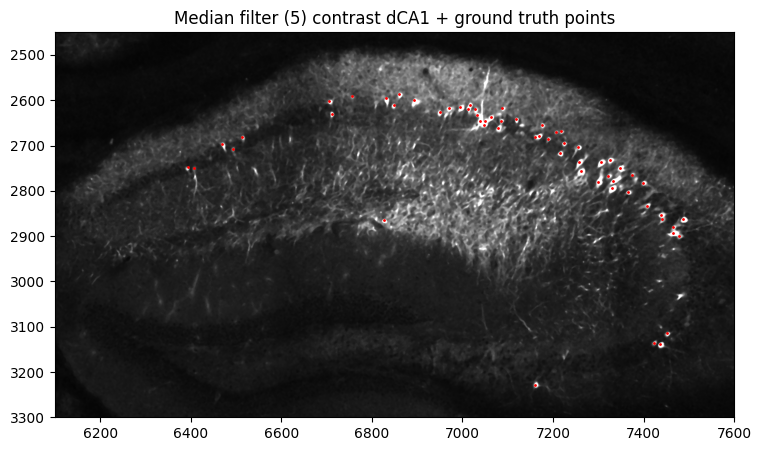

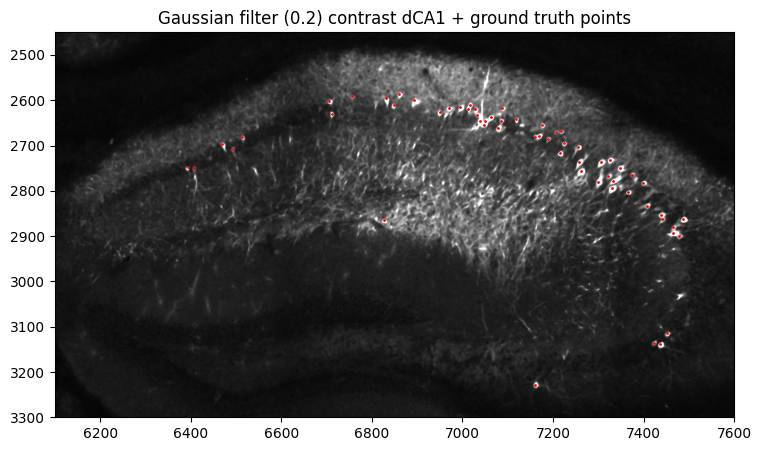

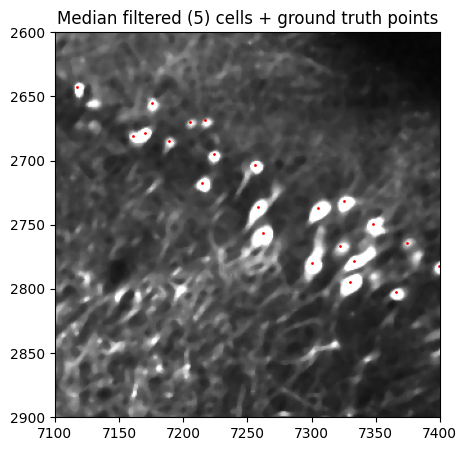

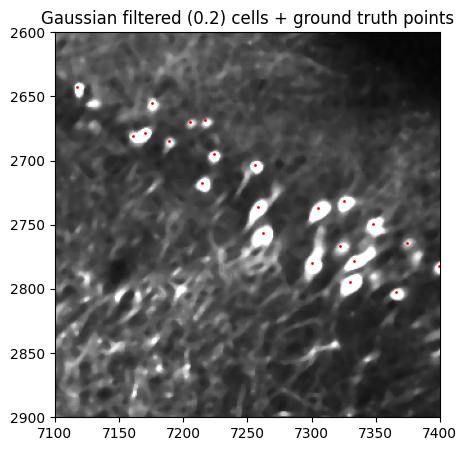

In [6]:
gaussian_sigma = 0.2

# Run gaussian filter
gaussian_filtered_img = scipy.ndimage.gaussian_filter(median_filtered_img.copy(), sigma=gaussian_sigma)

print("Median filtered image stats:")
print("Min:", np.min(median_filtered_img), "Max:", np.max(median_filtered_img))
print("Median:", np.median(median_filtered_img))
print("Mean:", np.mean(median_filtered_img))

print("\nGaussian filtered image stats:")
print("Min:", np.min(gaussian_filtered_img), "Max:", np.max(gaussian_filtered_img))
print("Median:", np.median(gaussian_filtered_img))
print("Mean:", np.mean(gaussian_filtered_img))

contrast_gaussian_filtered_img = auto_contrast(gaussian_filtered_img, alpha=0.1)
show_crop(contrast_median_filtered_img, points=gt_points, title=f"Median filter ({median_filter_size}) contrast dCA1 + ground truth points")
show_crop(contrast_gaussian_filtered_img, points=gt_points, title=f"Gaussian filter ({gaussian_sigma}) contrast dCA1 + ground truth points")
show_crop(contrast_median_filtered_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, 
          title=f"Median filtered ({median_filter_size}) cells + ground truth points")
show_crop(contrast_gaussian_filtered_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, 
          title=f"Gaussian filtered ({gaussian_sigma}) cells + ground truth points")

### Laplacian filter

Gaussian filtered image stats:
Min: 0.0 Max: 25193.601048856446
Median: 17.627451017744843
Mean: 63.983521536105954

Laplacian image stats:
Min: -18658.63233002237 Max: 12931.279365740587
Median: 0.0
Mean: -2.1930594491764025e-18


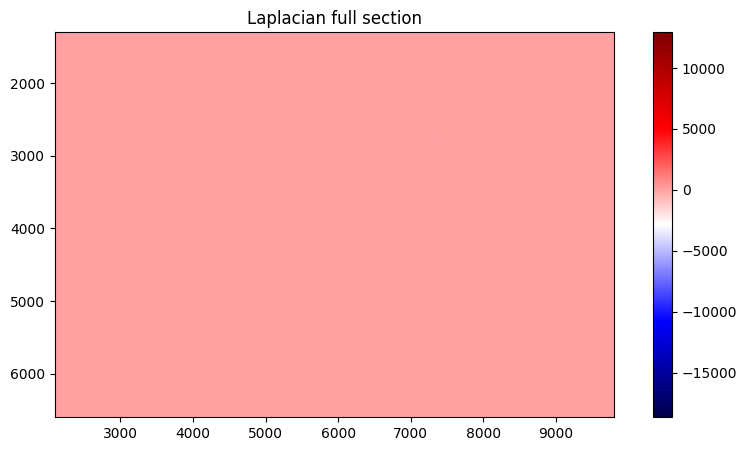

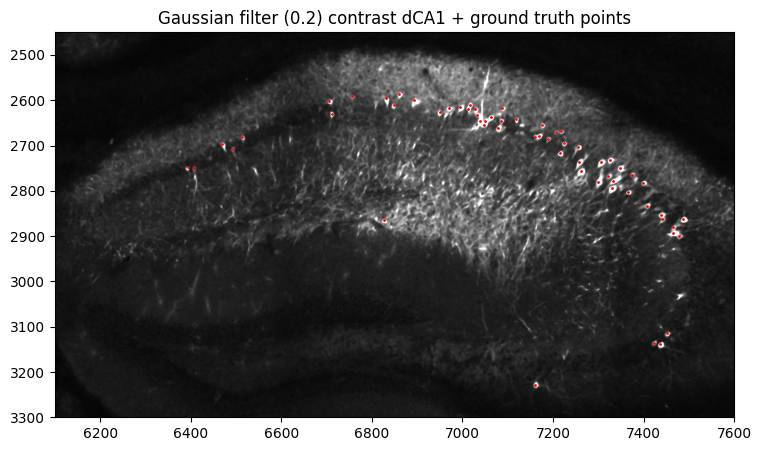

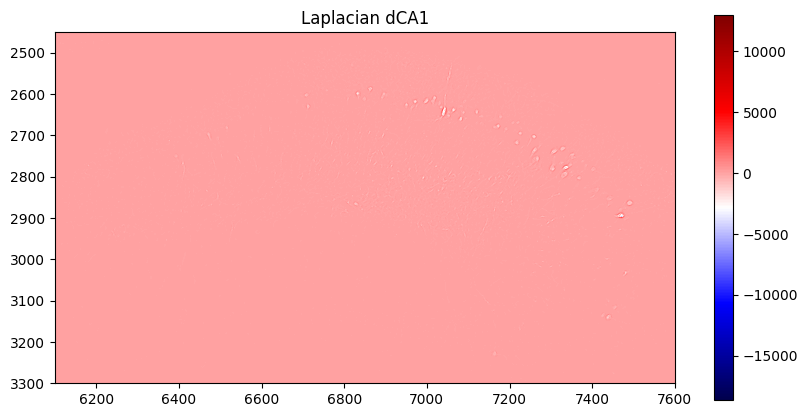

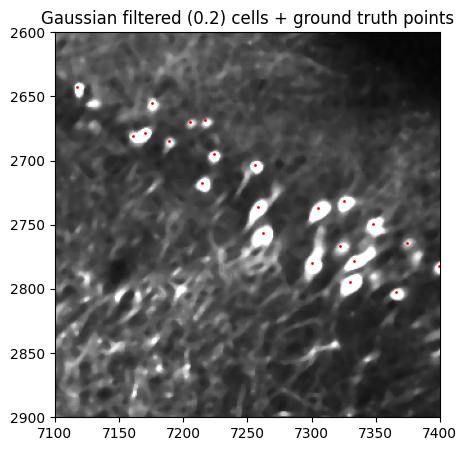

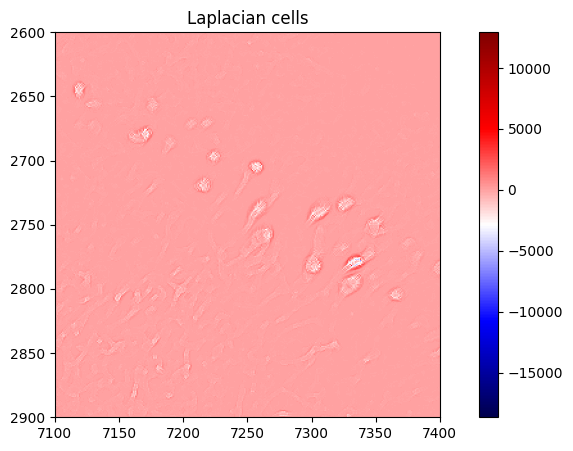

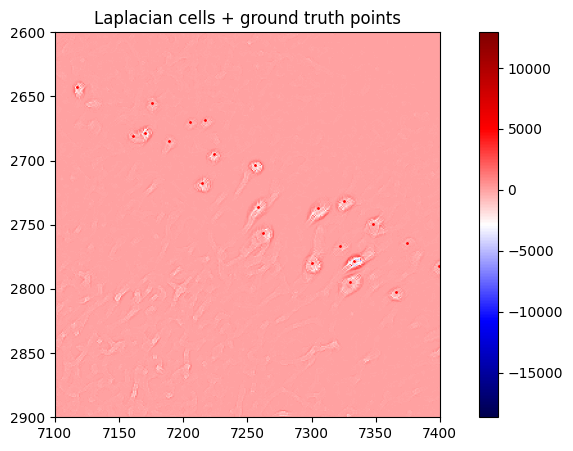

In [7]:
# Run Laplacian
laplacian_img = scipy.ndimage.laplace(gaussian_filtered_img.copy())

print("Gaussian filtered image stats:")
print("Min:", np.min(gaussian_filtered_img), "Max:", np.max(gaussian_filtered_img))
print("Median:", np.median(gaussian_filtered_img))
print("Mean:", np.mean(gaussian_filtered_img))

print("\nLaplacian image stats:")
print("Min:", np.min(laplacian_img), "Max:", np.max(laplacian_img))
print("Median:", np.median(laplacian_img))
print("Mean:", np.mean(laplacian_img))

show_crop(laplacian_img, x_crop=x_boundary, y_crop=y_boundary, title="Laplacian full section", cmap='seismic', colorbar=True)
show_crop(contrast_gaussian_filtered_img, points=gt_points, title=f"Gaussian filter ({gaussian_sigma}) contrast dCA1 + ground truth points")
show_crop(laplacian_img, title=f"Laplacian dCA1", cmap='seismic', colorbar=True)
show_crop(contrast_gaussian_filtered_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, 
          title=f"Gaussian filtered ({gaussian_sigma}) cells + ground truth points")
show_crop(laplacian_img, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title=f"Laplacian cells", cmap='seismic', colorbar=True)
show_crop(laplacian_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title=f"Laplacian cells + ground truth points", 
          cmap='seismic', colorbar=True)

### Thresholding

Laplacian mean: -2.1930594491764025e-18
Laplacian std: 19.952230163374004
Threshold value: 199.52230163374003


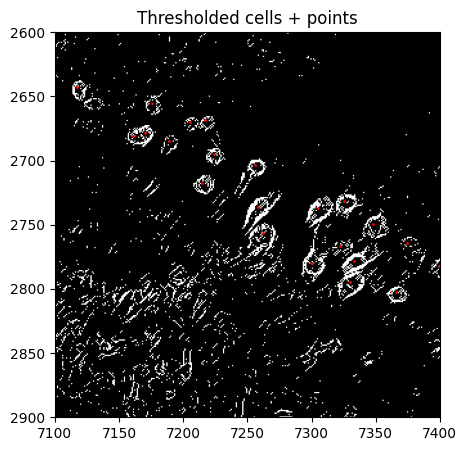

In [8]:
laplacian_mean = np.mean(laplacian_img)
print("Laplacian mean:", laplacian_mean)
laplacian_std = np.std(laplacian_img)
print("Laplacian std:", laplacian_std)

threshold_value = laplacian_mean + 10 * laplacian_std
print("Threshold value:", threshold_value)

thresholded_img = np.where(laplacian_img > threshold_value, 1, 0).astype(bool)

show_crop(thresholded_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title=f"Thresholded cells + points", cmap='gray')

Gaussian image mean: 63.983521536105954
Gaussian image std: 105.6273000714788
Threshold value: 2176.5295229656817


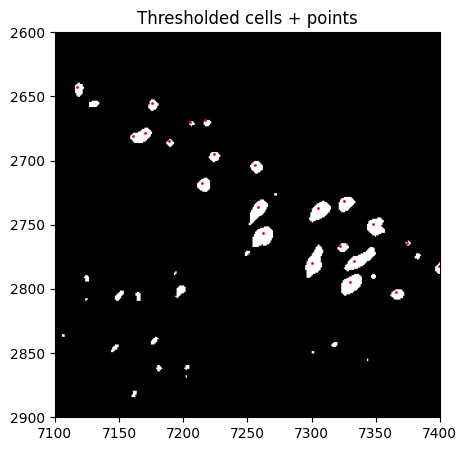

In [9]:
gaussian_img_mean = np.mean(gaussian_filtered_img)
print("Gaussian image mean:", gaussian_img_mean)
gaussian_img_std = np.std(gaussian_filtered_img)
print("Gaussian image std:", gaussian_img_std)

threshold_value = gaussian_img_mean + 20 * gaussian_img_std
print("Threshold value:", threshold_value)

thresholded_img = np.where(gaussian_filtered_img > threshold_value, 1, 0).astype(bool)

show_crop(thresholded_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title=f"Thresholded cells + points", cmap='gray')

[[2601 7043]
 [2601 7044]
 [2602 7042]
 ...
 [2666 7020]
 [2666 7021]
 [2667 7019]]
Min y: 2601
Max y: 2667
Min x: 7019
Max x: 7068


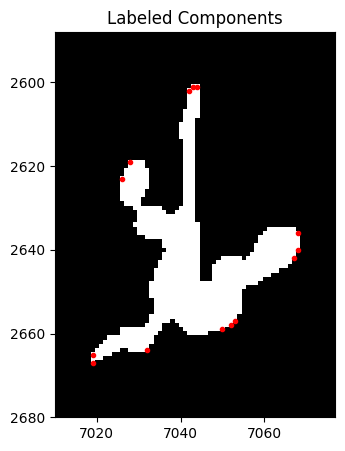

In [10]:
from skimage.measure import label, regionprops

# Label connected components
labeled_image = label(thresholded_img)

# Get properties of labeled regions
regions = regionprops(labeled_image)

# Find the index of the biggest connected component
max_area = 0
max_area_label = 0
for region in regions:
    if region.area > max_area:
        max_area = region.area
        max_area_label = region.label
        
# Extract the binary image for the biggest connected component
def get_component_binary_image(labeled_image, component_index):
    """
    Extract the binary image for a specific connected component index.
    
    Parameters:
    - labeled_image: Labeled image with connected components.
    - component_index: Index of the connected component to extract.
    
    Returns:
    - component_binary_image: Binary image of the extracted component.
    """
    component_binary_image = (labeled_image == component_index).astype(np.uint8)
    return component_binary_image

biggest_component_binary_image = get_component_binary_image(labeled_image, max_area_label)
#np.save("data/branching_component.npy", biggest_component_binary_image)

from scipy.spatial import Delaunay, ConvexHull
# Extract the coordinates of the foreground pixels
points = np.column_stack(np.nonzero(biggest_component_binary_image))
# Compute the convex hull
hull = ConvexHull(points)
# Get the coordinates of the points on the convex hull
hull_points = points[hull.vertices]

print(points)
min_y = np.min(points[:, 0])
max_y = np.max(points[:, 0])
min_x = np.min(points[:, 1])
max_x = np.max(points[:, 1])
x_spacing = int((max_x - min_x) * 0.2)
y_spacing = int((max_y - min_y) * 0.2)

print("Min y:", min_y)
print("Max y:", max_y)
print("Min x:", min_x)
print("Max x:", max_x)

x_hull_lim = (min_x - x_spacing, max_x + x_spacing)
y_hull_lim = (max_y + y_spacing, min_y - y_spacing)

# Visualize the binary image and labeled components
plt.figure(figsize=(10, 5))
plt.imshow(biggest_component_binary_image, cmap='gray')
plt.title('Labeled Components')
plt.xlim(x_hull_lim)
plt.ylim(y_hull_lim)
for pt in hull_points:
    plt.plot(pt[1], pt[0], 'ro', markersize=3)
plt.show()






## Cell class

In [11]:
from scipy.spatial import Delaunay, ConvexHull
from skimage.draw import polygon, ellipse
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist
import pickle
import math
from skimage.draw import ellipse_perimeter
import cv2
from skimage.measure import find_contours
from matplotlib.lines import Line2D


class Cell:
    def __init__(self, image: np.ndarray, z: int=None, index: int=None):
        """
        Initialize the cell object.
        
        Parameters:
        - image: 2D numpy array representing the binary image of the cell.
        - z: Z-coordinate of the cell.
        - index: Index of the cell.
        """
        self.image = image
        self.z = z
        self.index = index
        
    
    def get_area(self):
        """
        Compute the area of the cell image.
        
        Returns:
        - area: Area of the cell.
        """
        return np.sum(self.image)
    
    
    def get_centroid(self):
        """
        Compute the centroid of the cell image.
        
        Returns:
        - centroid: Tuple representing the (row, column) coordinates of the centroid.
        """
        # Find the coordinates of the foreground pixels
        rows, cols = np.nonzero(self.image)
        
        # Compute the centroid
        centroid_row = np.mean(rows)
        centroid_col = np.mean(cols)
        
        return (centroid_row, centroid_col)
    
    
    def get_medoid(self):
        """
        Compute the medoid of the cell image.
        
        Returns:
        - medoid: Tuple representing the (row, column) coordinates of the medoid.
        """
        # Find the coordinates of the foreground pixels
        points = np.column_stack(np.nonzero(self.image))
        
        # Compute the pairwise distances
        distances = cdist(points, points)
        
        # Compute the sum of distances for each point
        sum_distances = np.sum(distances, axis=1)
        
        # Find the index of the point with the minimum sum of distances
        medoid_index = np.argmin(sum_distances)
        
        # Get the coordinates of the medoid
        medoid = points[medoid_index]
        
        return (medoid[0], medoid[1])
    
    
    def get_convexity(self):
        """
        Compute the convexity of the cell
        
        Returns:
        - convexity: Convexity of the cell
        """
        convex_hull_image = self.get_convex_hull_image()
        return self.get_area() / np.sum(convex_hull_image)
    

    def get_boundary_points(self):
        """
        Get the boundary points of the binary image.
        
        Returns:
        - boundary_points: Coordinates of the boundary points.
        """
        contours = find_contours(self.image, level=0.5)
        if len(contours) == 0:
            raise ValueError("No contours found in the binary image")
        return contours[0]
        
        
    def get_convex_hull(self):
        """
        Get the points on the convex hull of a binary image.
        
        Parameters:
        - binary_image: 2D numpy array representing the binary image.
        
        Returns:
        - hull_points: Coordinates of the points on the convex hull.
        """
        # Extract the coordinates of the foreground pixels
        points = np.column_stack(np.nonzero(self.image))
        
        # Compute the convex hull
        hull = ConvexHull(points)
        
        # Get the coordinates of the points on the convex hull
        hull_points = points[hull.vertices]
        
        return hull_points
    
    
    def get_convex_hull_image(self):
        """
        Get the convex hull image of the cell
        
        Returns:
        - convex_hull_image: Binary image of the convex hull.
        """
        convex_hull_points = self.get_convex_hull()
        
        # Create a binary image
        convex_hull_image = np.zeros_like(self.image, dtype=bool)

        # Get the row and column coordinates of the convex hull points
        rr, cc = polygon(convex_hull_points[:, 0], convex_hull_points[:, 1], convex_hull_image.shape)

        # Fill the convex hull area in the binary image
        convex_hull_image[rr, cc] = 1
        return convex_hull_image
    
    
    def get_stats(self, section_img: np.ndarray, show=True):
        """
        Get the statistics of the cell.
        
        Parameters:
        - section_img: 2D numpy array representing the section image.
        """
        # Mask the section image with the cell binary image
        intensity_values = section_img[self.image]
        img_min = np.min(intensity_values)
        img_max = np.max(intensity_values)
        img_median = np.median(intensity_values)
        img_mean = np.mean(intensity_values)
        img_std = np.std(intensity_values)
        if show:
            print(str(self))
            print("\tShape (active pixels):", img.shape)
            print("\tMin:", img_min)
            print("\tMax:", img_max)
            print("\tMedian:", img_median)
            print("\tMean:", img_mean)
            print("\tStd:", img_std)
            print()
        return img_min, img_max, img_median, img_mean, img_std
    
    
    def locate(self, section_img: np.ndarray=None):
        """
        Shows the location of the cell in the image section.
        
        Parameters:
        - section: 2D numpy array representing the section image.
        """
        medoid = self.get_medoid()
        text_offset = np.max(self.image.shape) * 0.01
        
        # Plot the cell and section
        plt.figure(figsize=(10, 5))
        if section_img is not None:
            plt.imshow(section_img, cmap='gray')
        plt.imshow(self.image, cmap='gray', alpha=0.5)
        plt.plot(medoid[1], medoid[0], 'co', markersize=2)
        plt.text(medoid[1] + text_offset, medoid[0] - text_offset, f"{medoid}", fontsize=6, color='cyan')
        plt.title(str(self))
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()
    
    
    def show(self):
        """
        Show the cell image along with the convex hull and fitted ellipse.
        """
        # Get the convex hull points and image
        convex_hull_points = self.get_convex_hull()
        convex_hull_points = np.vstack([convex_hull_points, convex_hull_points[0]])  # Append the first point to close the loop
        convex_hull_image = self.get_convex_hull_image()
        centroid = self.get_centroid()
        medoid = self.get_medoid()
        ellipse_image = self.get_ellipse_image()
        
        # Get the limits for the plot
        min_y = np.min(convex_hull_points[:, 0])
        max_y = np.max(convex_hull_points[:, 0])
        min_x = np.min(convex_hull_points[:, 1])
        max_x = np.max(convex_hull_points[:, 1])
        x_spacing = int((max_x - min_x) * 0.2)
        y_spacing = int((max_y - min_y) * 0.2)
        x_hull_lim = (min_x - x_spacing, max_x + x_spacing)
        y_hull_lim = (max_y + y_spacing, min_y - y_spacing)
        text_offset = np.max([max_x - min_x, max_y - min_y]) * 0.01
        
        # Plot the cell and convex hull
        plt.figure(figsize=(10, 5))
        plt.imshow(self.image, cmap='gray', alpha=1)  # Plot the cell binary image
        plt.imshow(convex_hull_image, cmap=ListedColormap(['black', 'red']), alpha=0.25)  # Plot the convex hull fill
        plt.plot(convex_hull_points[:, 1], convex_hull_points[:, 0], 'r--', lw=1, alpha=0.5, label='Convex hull')  # Dashed lines for convex hull
        plt.plot(convex_hull_points[:, 1], convex_hull_points[:, 0], 'ro', markersize=3)  # Plot the convex hull points
        plt.plot(centroid[1], centroid[0], 'go', markersize=5, label='Centroid')  # Plot the centroid
        plt.text(centroid[1] + text_offset, centroid[0] - text_offset, f"{math.floor(centroid[0]), math.floor(centroid[1])}", fontsize=8, color='green', weight='bold')
        plt.plot(medoid[1], medoid[0], 'co', markersize=5, label='Medoid')  # Plot the centroid
        plt.text(medoid[1] + text_offset, medoid[0] - text_offset, f"{math.floor(medoid[0]), math.floor(medoid[1])}", fontsize=8, color='cyan', weight='bold')
        
        # Create a custom legend entry for the ellipse
        handles, labels = plt.gca().get_legend_handles_labels()
        custom_line = Line2D([0], [0], color='yellow', lw=2, label='Fitted ellipse')
        handles.append(custom_line)
        labels.append('Fitted ellipse')
        plt.imshow(ellipse_image, cmap=ListedColormap(['black', 'yellow']), alpha=0.5)  # Plot the fitted ellipse
    
        # Title and labels
        plt.title(str(self))
        plt.xlim(x_hull_lim)
        plt.ylim(y_hull_lim)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(handles=handles, labels=labels, fontsize='xx-small', framealpha=0.75)
        plt.show()

        
    def save(self, path):
        """
        Save the cell to a file using pickle.
        
        Parameters:
        - path: Path to the file where the object will be saved.
        """
        with open(path, 'wb') as file:
            pickle.dump(self, file)

            
    def fit_ellipse(self):
        """
        Fit an ellipse to the convex hull points of the binary image.
        
        Returns:
        - ellipse_params: A dictionary containing the parameters of the fitted ellipse.
        """
        # Extract the coordinates of the boundary points        
        boundary_points = self.get_boundary_points()
        
        # Convert the points to the format required by cv2.fitEllipse
        points = np.column_stack((boundary_points[:, 1], boundary_points[:, 0])).astype(np.float32)
        
        # Fit the ellipse to the points
        ellipse = cv2.fitEllipse(points)
        
        # Extract the ellipse parameters
        (center_x, center_y), (major_axis_length, minor_axis_length), angle = ellipse
        
        ellipse_params = {
            'centroid': (center_y, center_x),
            'major_axis_length': major_axis_length,
            'minor_axis_length': minor_axis_length,
            'orientation': np.deg2rad(angle)
        }
        return ellipse_params


    def get_ellipse_image(self, thickness=1):
        """
        Draw an ellipse on an image.
        
        Parameters:
        - thickness - Thickness of the ellipse boundary. -1 fills in the ellipse.
        
        Returns:
        - image_with_ellipse: the image with the ellipse drawn on it.
        """
        # Convert the image to uint8 if it is not already
        image = np.zeros(self.image.shape, dtype=np.uint8)
        
        # Convert the image to RGB if it is grayscale
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            
        ellipse_params = self.fit_ellipse()
        
        # Extract the ellipse parameters
        centroid = ellipse_params['centroid']
        print(centroid)
        major_axis_length = ellipse_params['major_axis_length']
        minor_axis_length = ellipse_params['minor_axis_length']
        orientation = np.rad2deg(ellipse_params['orientation'])
        
        # Draw the ellipse on the image
        image_with_ellipse = image.copy()
        cv2.ellipse(image_with_ellipse, (int(centroid[1]), int(centroid[0])), 
                    (int(major_axis_length / 2), int(minor_axis_length / 2)), 
                    orientation, 0, 360, (255, 255, 0), thickness)
        
        return image_with_ellipse
    

    def get_eccentricity(self):
        """
        Get the eccentricity of the fitted ellipse around the cell
        
        Returns:
        - eccentricity: Eccentricity of the fitted ellipse around the cell
        """
        ellipse_params = self.fit_ellipse()
        # Extract the semi-major and semi-minor axis lengths
        major_axis = ellipse_params['major_axis_length'] / 2
        minor_axis = ellipse_params['minor_axis_length'] / 2
        b = min(major_axis, minor_axis)
        a = max(major_axis, minor_axis)
        return np.sqrt(1 - (b / a) ** 2)
    
    
    def dice_ellipse(self):
        """
        Compute the Dice coefficient between the cell and the fitted ellipse.
        
        Returns:
        - dice_coefficient: Dice coefficient between the cell and the fitted ellipse.
        """
        ellipse_image = self.get_ellipse_image(thickness=-1)
        ellipse_image = cv2.cvtColor(ellipse_image, cv2.COLOR_BGR2GRAY)
        ellipse_image = ellipse_image.astype(bool)
        return compute_dice_coefficient(self.image, ellipse_image)
            
        
    def __str__(self):
        return f"Cell {self.z}-{self.index}"
    
    
    def __repr__(self):
        return self.__str__()

(2633.567138671875, 7045.46484375)


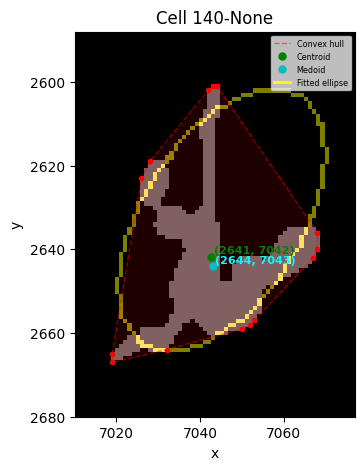

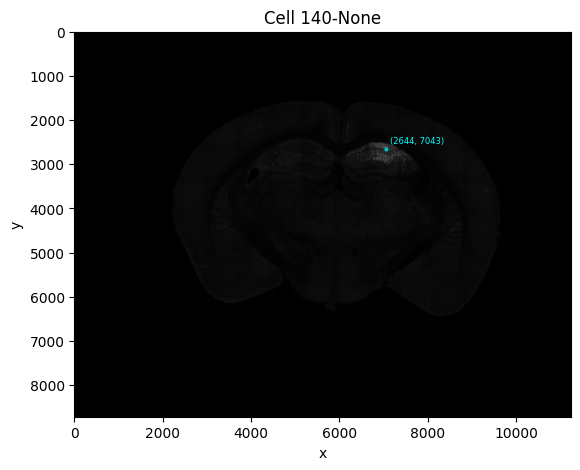

{'centroid': (2633.567138671875, 7045.46484375), 'major_axis_length': 38.41929626464844, 'minor_axis_length': 70.29239654541016, 'orientation': 0.563773825643662}
eccentricity: 0.8374173092019966
convexity: 0.43830665978316985
(2633.567138671875, 7045.46484375)
ellipse dice: 0.4779874213836478


In [12]:
branching_cell = np.load("data/branching_component.npy")
cell = Cell(branching_cell, 140)
cell.show()
cell.locate(contrast_gaussian_filtered_img)

params = cell.fit_ellipse()
print(params)

eccentricity = cell.get_eccentricity()
print("eccentricity:", eccentricity)
convexity = cell.get_convexity()
print("convexity:", convexity)
print("ellipse dice:", cell.dice_ellipse())